En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_mt as rrnn
import multitask_dep as mt

import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']
encoding_type = 'absolute'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [6]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# MultiTask SGD

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [13]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_sgd_absolute'

In [14]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4810606060606061, 'as': 0.48370273794002605, 'about': 0.5102040816326531}
Accuracy evaluando en etiquetas female
{'to': 1.0, 'as': 1.0, 'about': 1.0}
Accuracy evaluando en etiquetas male
{'to': 0.0, 'as': 0.0, 'about': 0.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0821444390127466 	 Validation loss: 2.0799792540275446 	 
  1%|          | 574/57400 [00:06<10:02, 94.24it/s]
Epoch 2 	 Training loss: 2.077252000051093 	 Validation loss: 2.0807770308801685 	 
  2%|▏         | 1148/57400 [00:13<09:57, 94.09it/s]
Epoch 3 	 Training loss: 2.0762345039055323 	 Validation loss: 2.080663600210416 	 
  3%|▎         | 1722/57400 [00:19<09:37, 96.42it/s]
Epoch 4 	 Training loss: 2.0758611404106593 	 Validation loss: 2.081698846008818 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:11, 99.84it/s]
Epoch 5 	 Training loss: 2.076538311479814 	 Validation loss: 2.080524804228443 	 
  5%|▌         | 2870/57400 [00:32<09:04, 100.13it/s]
Epoch 6 	 Training loss: 2.0760855471215596 	 Validation loss: 2.0813957634618725 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:12, 97.68it/s]
Epoch 7 	 Training loss: 2.0757824631102824 	 Validation loss: 2.0833770824690996 	 

3 epoch without improvement
  7%|

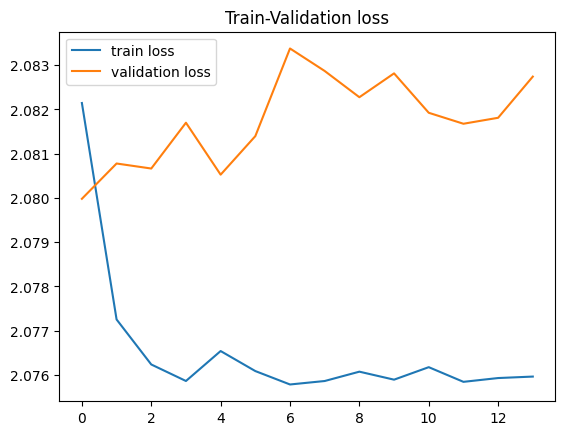

In [15]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [18]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5277777777777778, 'as': 0.5123859191655802, 'about': 0.4872448979591837}
Accuracy evaluando en etiquetas female
{'to': 0.14435695538057744, 'as': 0.15363881401617252, 'about': 0.1425}
Accuracy evaluando en etiquetas male
{'to': 0.8832116788321168, 'as': 0.8484848484848485, 'about': 0.8463541666666666}


# AdamW

In [19]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_adamw_absolute'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0759999972187266 	 Validation loss: 2.0794473219726046 	 
  1%|          | 574/57400 [00:07<10:45, 88.04it/s]
Epoch 2 	 Training loss: 2.0735027794223213 	 Validation loss: 2.075009891542338 	 
  2%|▏         | 1148/57400 [00:14<11:00, 85.12it/s]
Epoch 3 	 Training loss: 2.0703815176096527 	 Validation loss: 2.069464049096835 	 
  3%|▎         | 1722/57400 [00:22<10:33, 87.84it/s]
Epoch 4 	 Training loss: 2.0672136154739698 	 Validation loss: 2.0690967915421825 	 
  4%|▍         | 2296/57400 [00:29<10:38, 86.25it/s]
Epoch 5 	 Training loss: 2.0649843141176976 	 Validation loss: 2.0677841921984137 	 
  5%|▌         | 2870/57400 [00:36<10:42, 84.88it/s]
Epoch 6 	 Training loss: 2.0627930313867973 	 Validation loss: 2.068189026945728 	 
  6%|▌         | 3444/57400 [00:43<10:17, 87.44it/s]
Epoch 7 	 Training loss: 2.061829336844255 	 Validation loss: 2.065968428627919 	 
  7%|▋         | 4018/57400 [00:50<10:02, 88.64it/s]
Epoch 8 	 Training loss: 2.0597848983591

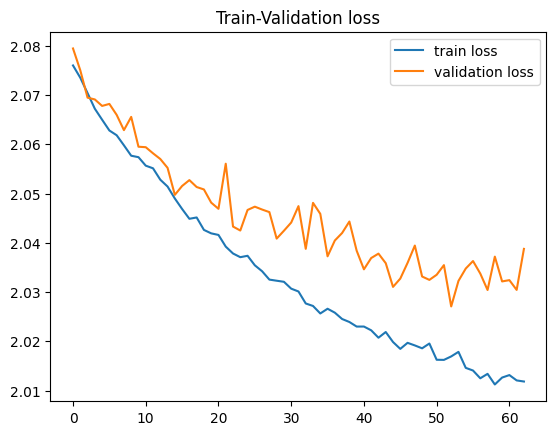

In [20]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [21]:
model =  rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5921717171717171, 'as': 0.5958279009126467, 'about': 0.6632653061224489}
Accuracy evaluando en etiquetas female
{'to': 0.5275590551181102, 'as': 0.5633423180592992, 'about': 0.5825}
Accuracy evaluando en etiquetas male
{'to': 0.6520681265206812, 'as': 0.6262626262626263, 'about': 0.7473958333333334}
